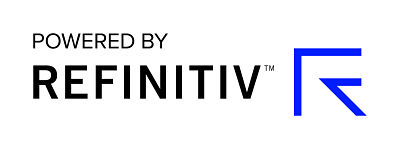


<center>
    <h3></h3>
    <h1> BANK LOANS - PRICING REQUEST TASK</h1>
</center>

<center>
    <b>Gabriel Esquivel, Research Analyst</b>
</center>

<center>
    <i>July 2019</i>
</center>


## Contents 

* [1. Introduction](#1.Introduction)
    * [1.1 Hiding toogles](#1.1.-Hiding-toogles)
    * [1.2 Importing modules](#1.2-Importing-modules)    
* [2. Extracting a LIN from outlook](#2.-Extracting-a-LIN-from-outlook)
    * [2.1.Bringing the last email to jupyter notebook](#2.1.-Bringing-the-last-email-to-jupyter-notebook) 
* [3. Identify and extract the LIN from last email](#3.-Identify-and-extract-the-LIN-from-last-email)
* [4. Making the SQL query and bring it as pandas data frame](#4.-Making-the-SQL-query-and-bring-it-as-pandas-data-frame)
    * [4.1.Conecting to SQL Data Base, making the query in SQL & bringing the SQL query as pandas data frame](#6.1.-Conecting-to-SQL-Data-Base,-making-the-query-in-SQL-&-bringing-the-SQL-query-as-pandas-data-frame)  
* [5. Choose a date](#5.-Choose-a-date)
* [6. Create a draft response](#6.-Send-an-email-response)  
    * [6.1.Identify the last email adress](#6.1.-Identify-the-last-email-adress)   
    * [6.2. Create an email draft with a html table](#6.2.-Send-the-email-with-a-html-table)       

     

## 1. Introduction 

Actual project has been designed with purpose of helping bank loans team on daily basics request for pricing task. This tool is divided into several stages which will be explanied next. 

The first step, is to capture the last email request with LIN number inside, then the tool will recognize this LIN(S). Once the LIN(S) has been recognized, a query will be made in SQL Data base with a certain information base on this LIN(S). Python will bring out a historical data base, hence, the quote date should be introduce in order to get the desire information. Finally, an email will be sent with the request that was made in previous steps in html format 

The main modules that will be used are: Pandas, win32com.client, re, pyodbc, sqlalchemy, smtplib and ipywidgets. 

###### 1.1 Hiding toogles

The main purpose of this is to hide python code using ```hide_toogle()``` function in case you do not prefer to see it or manipulate it

In [ ]:
st = "07/08/2019"
et = "07/08/2019"
hour = '3PM' 

In [ ]:
import random
from IPython.display import HTML
def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

##### 1.2 Importing modules

In [ ]:
import win32com.client
import re
import pyodbc
import pandas as pd
import sqlalchemy
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import smtplib
import datetime
from IPython.display import display

hide_toggle()

## 2. Extracting a LIN (S) from outlook 

The following code extract the last email on the folder,then takes the LIN from the email

##### 2.1 Bringing the last email to jupyter notebook:

In [ ]:
outlook = win32com.client.Dispatch("Outlook.Application").GetNamespace("MAPI")
inbox = outlook.GetDefaultFolder(6).Folders.Item("TRPS LP")
messages = inbox.Items
message = messages.GetLast()
body_content = message.body
#print(body_content)

## 3. Identify and extract the LIN(S) from last email 

In [ ]:
lins = re.findall("[A-Z0-9]+[0-9]+[A-Z0-9]+[A-Z0-9]+[A-Z0-9]+[A-Z0-9]+[A-Z0-9]+[A-Z0-9]+[0-9]+[A-Z]+[A-Z]+[0-9]+[A-Z0-9]", body_content) 
str1 = ''.join(lins)
lins

## 4. Making an SQL query

##### 4.1 Conecting to SQL Data Base, making the query in SQL & bringing the SQL query as pandas data frame

In [ ]:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=10.91.141.195;DATABASE=Pricing_BankLoans;UID=pricing_admin;PWD=admin')
lins = lins
lins_in_query = "','".join(lins)
print(lins_in_query)
hour = hour 
hour_in_query = ''.join(hour)
print(hour_in_query)

query='''
SELECT FIN AS 'LIN', Borrower, Facility, Avg_Of_Bid, Avg_Of_Ask, Mean_Of_Mean, Number_Of_Quotes, BROKERS, Date_Of_Quote
FROM [Main].[Z6_Quote_Information]
WHERE FIN IN ('{}') and File_Type in ('{}')
ORDER BY Upload_Date DESC
'''.format(lins_in_query, hour_in_query)


print(query)
df = pd.read_sql_query(query, conn)
type(df['Date_Of_Quote'])
df.sort_values('Date_Of_Quote')
df.set_index(['Date_Of_Quote'])
df['Date_Of_Quote']=pd.to_datetime(df.Date_Of_Quote)


## 5. Choose a date  

It is important to mention that date should the date that has been requested on the email

In [ ]:
filtered_date = None

def print_datesIt(st, et):
    global filtered_date
    st=pd.Timestamp(st)
    et=pd.Timestamp(et)
    df['Date_Of_Quote']=pd.to_datetime(df.Date_Of_Quote)
    stat_df = (df['Date_Of_Quote'] >= st) & (df['Date_Of_Quote'] <= et)
    df_2 = df.loc[stat_df, :]
    filtered_date = df_2
    return df_2

_ = interact(print_datesIt,
             st=widgets.DatePicker(value=pd.to_datetime(st)),
             et=widgets.DatePicker(value=pd.to_datetime(et)))


## 6. Create a draft response

##### 6.1. Identify the last email adress 

In [ ]:
from win32com.client import Dispatch

def getEmailAddress():
    outlook = Dispatch("Outlook.Application").GetNamespace("MAPI")
    inbox = outlook.GetDefaultFolder("6").Folders.Item("TRPS LP")
    last = inbox.Items 
    folders = last.GetLast()

    if folders.SenderEmailType=='EX':
        return folders.Sender.GetExchangeUser().PrimarySmtpAddress
    else:
        return folders.SenderEmailAddress

getEmailAddress()

##### 6.2. Create an email draft with a data frame table

In [ ]:
import win32com.client
import pandas as pd

#filtered_date = pd.read_csv('sample.csv') # Sample data

outlook = win32com.client.Dispatch("Outlook.Application").GetNamespace("MAPI")
inbox = outlook.GetDefaultFolder(6).Folders.Item("TRPS LP") 
messages = inbox.Items

count = 0
msg = messages.GetLast() # Gets the most recent email
while count < 1: # Limit to last two emails
    reply = msg.ReplyAll()
    reply.HTMLBody = 'Hello,<br><br><br>Please find attached your request<br><br><br>' + filtered_date.to_html(index=False) +'<br>Thank you<br><br><hr><br>' + msg.HTMLbody
    reply.Save() # Save to draft
    count += 1
    msg = messages.GetPrevious() # Get the next most recent email and redo the loop
